In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools
from rdkit.ML.Descriptors import MoleculeDescriptors

## A) （準備１）構造式の描き

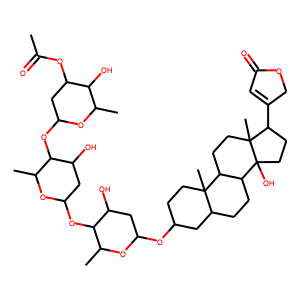

In [2]:
# acetyldigitoxin
mol = Chem.MolFromSmiles("O1C(C)C(OC2OC(C)C(O)C(OC(=O)C)C2)C(O)CC1OC1C(OC(OC2CC3CCC4C(CCC5(C)C(CCC45O)C4=CC(OC4)=O)C3(CC2)C)CC1O)C")
Draw.MolToImage(mol)

## B) （準備２）データ保存

## C) （準備３）記述子の計算

In [3]:
descriptors_list = [item[0] for item in Descriptors.descList]
mol_descriptors_calc = MoleculeDescriptors.MolecularDescriptorCalculator(descriptors_list)

## D) （準備４）lnKa, fb, RMSE, R値の計算

In [4]:
def calc_lnka(fb):
    fb = fb*0.99 + 0.005
    C = 0.3
    lnka = C*np.log(fb/(1-fb))
    return lnka

def calc_fb(lnka):
    C = 0.3
    e_lnka = np.exp(lnka/C)
    fb = e_lnka/(1+e_lnka)
    return fb

def fb_rmse_loss(y_exp,y_pred):
    fb_exp = calc_fb(y_exp)
    fb_pred = calc_fb(y_pred)
    rmse = np.sqrt(np.sum((y_exp-y_pred)**2)/len(y_exp))
    return rmse

def lnka_R_value(y_exp,y_pred):
    dif_exp = y_exp - np.mean(y_exp)
    dif_pred = y_pred - np.mean(y_pred)
    R1 = np.sum(dif_exp*dif_pred)
    R2 = np.sqrt(np.sum(dif_exp**2)*np.sum(dif_pred**2))
    R = R1/R2
    return R

## E) Small molecule データを用いたElasticNet回帰モデルの構築・選択

In [5]:
sm_data = pd.read_csv('sm.csv')
sm_df = pd.DataFrame(sm_data,columns=sm_data.columns)

sm_SMILES = sm_df["SMILES"].values

sm_desc_data = []
for idx,m in enumerate(sm_SMILES):
    mol = Chem.MolFromSmiles(m)
    mol_desc = mol_descriptors_calc.CalcDescriptors(mol)
    sm_desc_data.append(mol_desc)

In [6]:
from sklearn.preprocessing import StandardScaler
sm_std = StandardScaler()
X_sm = np.array(sm_desc_data)
X_sm = sm_std.fit_transform(X_sm)
y_sm = calc_lnka(np.array(sm_df["PPB (fb)"].values))

In [7]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline

In [8]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.constraints import maxnorm
from keras import regularizers

In [9]:
import sys, os
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [12]:
queue=[]
x={1,2}
y={}
z={4,5}
queue.append((x,y,z,4))
queue.append((x,y,z,3))
queue.append((x,y,z,8))
print(queue)

[({1, 2}, {}, {4, 5}, 4), ({1, 2}, {}, {4, 5}, 3), ({1, 2}, {}, {4, 5}, 8)]


In [24]:
sorted(queue,key=lambda x: x[3])

[({1, 2}, {}, {4, 5}, 3), ({1, 2}, {}, {4, 5}, 4), ({1, 2}, {}, {4, 5}, 8)]

In [22]:
student_tuples = [
    ('john', 'A', 15),
    ('jane', 'B', 12),
    ('dave', 'B', 10),
]

In [23]:
sorted(student_tuples, key=lambda student: student[2])

[('dave', 'B', 10), ('jane', 'B', 12), ('john', 'A', 15)]

In [33]:
ls = Lasso(alpha=0.004)
ls.fit(X_sm,y_sm)
ls.score(X_sm,y_sm)

0.6305366523826468

In [60]:
cp_data = pd.read_csv('cpd.csv')
cp_df = pd.DataFrame(cp_data,columns=cp_data.columns)

cp_SMILES = cp_df["SMILES"].values

cp_desc_data = []
for idx,m in enumerate(cp_SMILES):
    mol = Chem.MolFromSmiles(m)
    mol_desc = mol_descriptors_calc.CalcDescriptors(mol)
    cp_desc_data.append(mol_desc)

In [61]:
cp_std = StandardScaler()
X_cp = np.array(cp_desc_data)
X_cp = cp_std.fit_transform(X_cp)
y_cp = calc_lnka(np.array(cp_df["PPB(fb)"].values))

In [62]:
def LassoP(P):
    p_features = list(P)
    lasso = Lasso(alpha=0.007)
    lasso.fit(X_sm[:,p_features],y_sm)
    return lasso.coef_,lasso.score(X_sm[:,p_features],y_sm)

In [63]:
def supp(b):
    b_nz = np.nonzero(b)[0]
    return set(b_nz)

In [64]:
prio_queue = []
k_solution = []
P = set(range(200))

In [65]:
beta_star,sc = LassoP(P)
prio_queue.append((beta_star,P,set(),sc))
K = 5    

In [66]:
for k in range(K):
    beta,S,F,_ = prio_queue.pop(0)
    k_solution.append(beta)
    for i in supp(beta):
        if i not in F:
            S.remove(i)
            beta_prime,sc = LassoP(S)
            prio_queue.append((beta_prime,S,F,sc))
            prio_queue = sorted(prio_queue,key = lambda x:x[3])
            F.add(i)

In [69]:
k_solution_alpha = []

for k in range(K):
    supp = np.nonzero(k_solution[k])[0]
    reg = Lasso(random_state=0, max_iter=1000)

    alphas = np.logspace(-3, 3, 100)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
              'lnka_r':make_scorer(lnka_R_value)}

    clf = GridSearchCV(reg, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
    clf.fit(X_sm[:, supp], y_sm)
    """
    scores = -clf.cv_results_['mean_test_fb_rmse']
    scores_std = clf.cv_results_['std_test_fb_rmse']
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(alphas, scores)

    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)

    plt.semilogx(alphas, scores + std_error, 'b--')
    plt.semilogx(alphas, scores - std_error, 'b--')

    # alpha=0.2 controls the translucency of the fill color
    plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('fb rmse +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.min(scores), linestyle='--', color='.5')
    plt.xlim([alphas[0], alphas[-1]])
    plt.title('hyperparameter and fb RMSE')
    """
    print('ELS features ',k+1," : #supp(beta)= ",len(supp))
    k_solution_alpha.append(clf.best_params_)
    print('Small molecule data')
    #print('fb_rmse: ',-clf.cv_results_['mean_test_fb_rmse'])
    #print('lnka_R : ',clf.cv_results_['mean_test_lnka_r'])
    print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
    print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
    print('Best alpha. :',clf.best_params_)
    
    y_cp_pred = clf.best_estimator_.predict(X_cp[:,supp])
    print('Cyclic peptide drug')
    print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
    print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))
    
    print("=====================")
    #plt.show()
    
    

ELS features  1  : #supp(beta)=  87
Small molecule data
Best fb_rmse: 0.4806055151278656
Best lnKa_R : 0.7350440055991989
Best alpha. : {'alpha': 0.002009233002565048}
Cyclic peptide drug
fb RMSE : 0.6068802997765275
lnKa R. : 0.4711615417424751
ELS features  2  : #supp(beta)=  46
Small molecule data
Best fb_rmse: 0.5381812394776957
Best lnKa_R : 0.6511219044748475
Best alpha. : {'alpha': 0.007054802310718645}
Cyclic peptide drug
fb RMSE : 0.6175551829013617
lnKa R. : 0.3635482846694282
ELS features  3  : #supp(beta)=  42
Small molecule data
Best fb_rmse: 0.527976274772644
Best lnKa_R : 0.6670461755111478
Best alpha. : {'alpha': 0.0015199110829529332}
Cyclic peptide drug
fb RMSE : 0.6403680519776377
lnKa R. : 0.28794362944139734
ELS features  4  : #supp(beta)=  44
Small molecule data
Best fb_rmse: 0.5116709715152155
Best lnKa_R : 0.689415857283059
Best alpha. : {'alpha': 0.001}
Cyclic peptide drug
fb RMSE : 0.6486937961436214
lnKa R. : 0.3156057310184322
ELS features  5  : #supp(beta)=

#### Ridge

In [70]:
k_solution_alpha = []

for k in range(K):
    supp = np.nonzero(k_solution[k])[0]
    reg = Ridge(random_state=0, max_iter=1000)

    alphas = np.logspace(-3, 3, 100)

    tuned_parameters = [{'alpha': alphas}]
    n_folds = 5

    scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
              'lnka_r':make_scorer(lnka_R_value)}

    clf = GridSearchCV(reg, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
    clf.fit(X_sm[:, supp], y_sm)
    
    """
    scores = -clf.cv_results_['mean_test_fb_rmse']
    scores_std = clf.cv_results_['std_test_fb_rmse']
    plt.figure().set_size_inches(8, 6)
    plt.semilogx(alphas, scores)

    # plot error lines showing +/- std. errors of the scores
    std_error = scores_std / np.sqrt(n_folds)

    plt.semilogx(alphas, scores + std_error, 'b--')
    plt.semilogx(alphas, scores - std_error, 'b--')

    # alpha=0.2 controls the translucency of the fill color
    plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

    plt.ylabel('fb rmse +/- std error')
    plt.xlabel('alpha')
    plt.axhline(np.min(scores), linestyle='--', color='.5')
    plt.xlim([alphas[0], alphas[-1]])
    plt.title('hyperparameter and fb RMSE')
    """
    print('ELS features ',k+1," : #supp(beta)= ",len(supp))
    k_solution_alpha.append(clf.best_params_)
    print('Small molecule data')
    #print('fb_rmse: ',-clf.cv_results_['mean_test_fb_rmse'])
    #print('lnka_R : ',clf.cv_results_['mean_test_lnka_r'])
    print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
    print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
    print('Best alpha. :',clf.best_params_)
    
    y_cp_pred = clf.best_estimator_.predict(X_cp[:,supp])
    print('Cyclic peptide drug')
    print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
    print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))
    
    print("======================")
    #plt.show()
    
    

ELS features  1  : #supp(beta)=  87
Small molecule data
Best fb_rmse: 0.4799186667506084
Best lnKa_R : 0.7330883115633056
Best alpha. : {'alpha': 107.22672220103232}
Cyclic peptide drug
fb RMSE : 0.6233378000722418
lnKa R. : 0.4374903053809144
ELS features  2  : #supp(beta)=  46
Small molecule data
Best fb_rmse: 0.5385876042485694
Best lnKa_R : 0.6502711260471374
Best alpha. : {'alpha': 107.22672220103232}
Cyclic peptide drug
fb RMSE : 0.6114051100052404
lnKa R. : 0.3698266308176288
ELS features  3  : #supp(beta)=  42
Small molecule data
Best fb_rmse: 0.5291071499533655
Best lnKa_R : 0.6645115711829412
Best alpha. : {'alpha': 40.37017258596558}
Cyclic peptide drug
fb RMSE : 0.6314141531519034
lnKa R. : 0.3298360852716482
ELS features  4  : #supp(beta)=  44
Small molecule data
Best fb_rmse: 0.5116641882349197
Best lnKa_R : 0.6898593763705424
Best alpha. : {'alpha': 0.9326033468832199}
Cyclic peptide drug
fb RMSE : 0.649017377166414
lnKa R. : 0.3221939840563968
ELS features  5  : #supp(b

#### ElasticNet 

In [71]:
k_solution_alpha = []

for k in range(K):
    supp = np.nonzero(k_solution[k])[0]
    reg = ElasticNet(random_state=0, max_iter=1000)

    alphas2 = np.logspace(-6, 4, 50)
    l1_ratios = np.logspace(-6,4,50)

    tuned_parameters = [{'alpha': alphas2,'l1_ratio':l1_ratios}]

    n_folds = 5

    scorer = {'fb_rmse':make_scorer(fb_rmse_loss,greater_is_better=False),
              'lnka_r':make_scorer(lnka_R_value)}

    clf = GridSearchCV(reg, tuned_parameters,scoring=scorer, cv=n_folds, refit='fb_rmse')
    clf.fit(X_sm[:, supp], y_sm)

    print('ELS features ',k+1," : #supp(beta)= ",len(supp))
    k_solution_alpha.append(clf.best_params_)
    print('Small molecule data')
    #print('fb_rmse: ',-clf.cv_results_['mean_test_fb_rmse'])
    #print('lnka_R : ',clf.cv_results_['mean_test_lnka_r'])
    print('Best fb_rmse:',-clf.cv_results_['mean_test_fb_rmse'][clf.best_index_])
    print('Best lnKa_R :',clf.cv_results_['mean_test_lnka_r'][clf.best_index_])
    print('Best alpha. :',clf.best_params_)
    
    y_cp_pred = clf.best_estimator_.predict(X_cp[:,supp])
    print('Cyclic peptide drug')
    print('fb RMSE :', fb_rmse_loss(y_cp,y_cp_pred))
    print('lnKa R. :', lnka_R_value(y_cp,y_cp_pred))
    
    print("============")

KeyboardInterrupt: 